## Image Captioning - Use Cases

- Here we will learn how to use Transformers to solve a multi-modal problem involving both images and text: **image captioning.**

- **Automated image captioning, or image annotation, has a wide variety of applications:**
    - *One of the most prominent applications is image retrieval in search engines. Automated image captioning can be used to retrieve all the images belonging to a certain class (for example, a cat) as per the user’s request.* 
    
    - *Another application can be in social media where, when an image is uploaded by a user, the image is automatically captioned so that the user can either refine the generated caption or post it as it is.*

## Approach

- Solving this will require two Transformer models: 
    - one to generate an image representation and 
    - the other to generate the relevant caption. 

- Once the image representation is generated, it will be fed as one of the inputs to the text-based Transformer model. 

- The text-based Transformer model will be trained to predict the next token in the caption given the current caption, at a given time step.


- Looking at the image caption generation pipeline at a very high level, we have two main components:
    1. A pretrained Vision Transformer model that takes in an image and produces a 1D hidden representation of the image

    2. A text-based Transformer decoder model that can decode the hidden image representation to a series of token IDs
    
    
We will use a pretrained Transformer model to generate image representations. Known as the **Vision Transformer (ViT)**, it has been trained on the ImageNet dataset and has delivered great performance on the ImageNet classification task.

## Imports

In [1]:
from __future__ import print_function
import os
from pathlib import Path
import json
import collections
import numpy as np
import pandas as pd
from six.moves import range
from six.moves.urllib.request import urlretrieve
import tensorflow as tf
from tokenizers import BertWordPieceTokenizer
import tensorflow_hub as hub
import tensorflow.keras.backend as K
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

## Data

In [3]:
data_dir = Path('data')

# training images
trainval_image_dir = data_dir / 'train2014'
# captions of training images
trainval_captions_dir = data_dir / 'annotations_trainval2014'
# validation images
test_image_dir = data_dir / 'val2017'
# captions of validation images
test_captions_dir = data_dir / 'annotations_trainval2017'


trainval_captions_filepath = trainval_captions_dir/'captions_train2014.json'
test_captions_filepath = test_captions_dir/'captions_val2017.json'

### Split training/validation datasets

In [12]:
all_filepaths = np.array([os.path.join(trainval_image_dir, f) for f in os.listdir(trainval_image_dir)])
rand_indices = np.arange(len(all_filepaths))
np.random.shuffle(rand_indices)

split = int(len(all_filepaths)*0.8)

# 80-20 split
train_filepaths, valid_filepaths = all_filepaths[rand_indices[:split]], all_filepaths[rand_indices[split:]] 

print(f"Train dataset size: {len(train_filepaths)}")
print(f"Valid dataset size: {len(valid_filepaths)}")

Train dataset size: 66226
Valid dataset size: 16557


## Processing data 

Here we generate the filepaths for the images and read the captions from the `.json` files containing captions. Finally we create three dataframes; `train_captions_df`, `valid_captions_df` and `test_captions_df`.

Each will contain the following columns,

- `image_id` – Identifies an image (used to generate the file path)
- `image_filepath` - filepath to the image
- `caption` - original caption
- `preprocessed_caption` - preprocessed version of the caption

In [16]:
os.listdir('data/annotations_trainval2014/')

['captions_train2014.json',
 'captions_val2014.json',
 'instances_train2014.json',
 'instances_val2014.json',
 'person_keypoints_train2014.json',
 'person_keypoints_val2014.json']

In [39]:
with open(trainval_captions_filepath, 'r') as f:
    trainval_data = json.load(f)

print(trainval_data.keys())
trainval_data['annotations'][:2]

dict_keys(['info', 'images', 'licenses', 'annotations'])


[{'image_id': 318556,
  'id': 48,
  'caption': 'A very clean and well decorated empty bathroom'},
 {'image_id': 116100,
  'id': 67,
  'caption': 'A panoramic view of a kitchen and all of its appliances.'}]

In [42]:
with open(trainval_captions_filepath, 'r') as f:
    trainval_data = json.load(f)

trainval_captions_df = pd.json_normalize(trainval_data, "annotations")

# create the column called image_filepath by prefixing the root directory path to 
# the image_id and appending the extension .jpg. 
trainval_captions_df['image_filepath'] = trainval_captions_df["image_id"].apply(
    lambda x: os.path.join(trainval_image_dir, 'COCO_train2014_'+format(x, '012d')+'.jpg')
)

# only keep the data points where the image_filepath values are 
# in the training images we stored in train_filepaths:
train_captions_df = trainval_captions_df[trainval_captions_df["image_filepath"].isin(train_filepaths)]


def preprocess_captions(image_captions_df):
    """
    Preprocessing the captions:
    - Added two special tokens, [START] and [END], to denote the start and the 
      end of each caption respectively
    - Converted the captions to lowercase
    - Removed everything that is not a word, character, or space
    """
    
    image_captions_df["preprocessed_caption"] = "[START] " + image_captions_df["caption"].str.lower().str.replace('[^\w\s]','') + " [END]"
    return image_captions_df


train_captions_df = preprocess_captions(train_captions_df)
valid_captions_df = trainval_captions_df[trainval_captions_df["image_filepath"].isin(valid_filepaths)]
valid_captions_df = preprocess_captions(valid_captions_df)


# For test data
with open(test_captions_filepath, 'r') as f:
    test_data = json.load(f)
    
test_captions_df = pd.json_normalize(test_data, "annotations")
test_captions_df["image_filepath"] = test_captions_df["image_id"].apply(
    lambda x: os.path.join(test_image_dir, format(x, '012d')+'.jpg')
)
test_captions_df = preprocess_captions(test_captions_df)


train_captions_df.head()

C:\Users\Amit Vikram Raj\AppData\Local\Temp\ipykernel_12860\1126691036.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_captions_df["preprocessed_caption"] = "[START] " + image_captions_df["caption"].str.lower().str.replace('[^\w\s]','') + " [END]"
C:\Users\Amit Vikram Raj\AppData\Local\Temp\ipykernel_12860\1126691036.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_captions_df["preprocessed_caption"] = "[START] " + image_captions_df["caption"].str.lower().str.replace('[^\w\s]','') + " [

,image_id,id,caption,image_filepath,preprocessed_caption
0,318556,48,A very clean and well decorated empty bathroom,data\train2014\COCO_train2014_000000318556.jpg,[START] a very clean and well decorated empty ...
1,116100,67,A panoramic view of a kitchen and all of its a...,data\train2014\COCO_train2014_000000116100.jpg,[START] a panoramic view of a kitchen and all ...
2,318556,126,A blue and white bathroom with butterfly theme...,data\train2014\COCO_train2014_000000318556.jpg,[START] a blue and white bathroom with butterf...
3,116100,148,A panoramic photo of a kitchen and dining room,data\train2014\COCO_train2014_000000116100.jpg,[START] a panoramic photo of a kitchen and din...
4,379340,173,A graffiti-ed stop sign across the street from...,data\train2014\COCO_train2014_000000379340.jpg,[START] a graffiti-ed stop sign across the str...


## Visualize some data

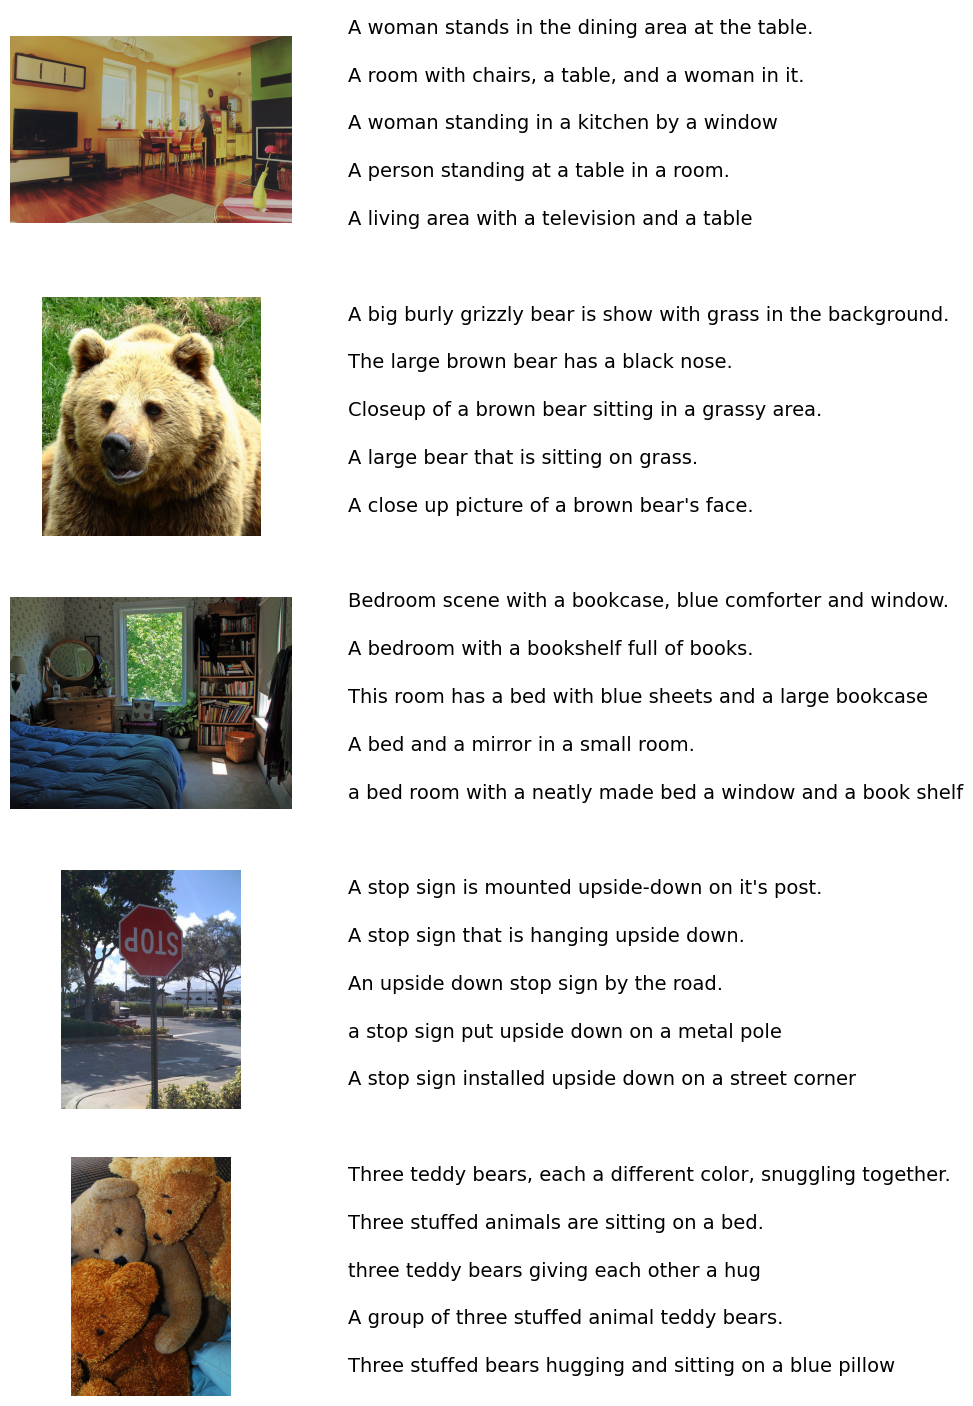

In [43]:
sample_data = test_captions_df.groupby("image_filepath")["caption"].agg(list).iloc[:5]

fig, axes = plt.subplots(5, 2, figsize=(8,18))

for ax_row, index, sample in zip(axes, sample_data.index, sample_data):
    
    ax_row[0].imshow(Image.open(index))
    ax_row[0].axis("off")
    text_y = 0.9
    for cap in sample:
        ax_row[1].text(0, text_y, cap, fontsize=14)
        text_y -= 0.2
    ax_row[1].axis("off")

## Analysing some statistics about the data

In [44]:
# We will take a small sample of the first 1,000
# images from the training dataset and look at image sizes:

from PIL import Image

n_samples = 1000

train_image_stats_df = train_captions_df.loc[:n_samples, "image_filepath"].apply(lambda x: Image.open(x).size)
train_image_stats_df = pd.DataFrame(train_image_stats_df.tolist(), index=train_image_stats_df.index)
train_image_stats_df.describe()

# We can see that most images have a resolution of 640x640. We will later need
# to resize images to 224x224 to match the model’s input requirements.

,0,1
count,790.000000,790.000000
mean,569.264557,499.310127
std,95.599196,100.593757
min,331.000000,182.000000
25%,480.000000,427.000000
50%,640.000000,480.000000
75%,640.000000,640.000000
max,640.000000,640.000000


In [46]:
train_vocabulary = train_captions_df["preprocessed_caption"].str.split(" ").explode().value_counts()

print(len(train_vocabulary[train_vocabulary>=25]))
# This tells us that 4,493 words occur at least 25 times in our train dataset. 
# We use this as our vocabulary size

4493


## Tokenizing the data

In [50]:
from tokenizers import BertWordPieceTokenizer

# Initialize an empty BERT Tokenizer
tokenizer = BertWordPieceTokenizer(unk_token='[UNK]',
                                   clean_text=False,
                                   lowercase=False)

tokenizer.train_from_iterator(
    train_captions_df.preprocessed_caption.tolist(),
    vocab_size=4500,
    special_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
)

The `train_from_iterator()` function takes in several arguments:
- `iterator` – An iterable that produces a string (containing the caption) as one item.
- `vocab_size` – Size of the vocabulary.
- `special_tokens` – Special tokens that will be used in our data. Specifically we use [PAD] (to denote padding), [UNK] (to denote OOV tokens), [START] (to denote the start), and [END] (to denote the end). These tokens will get assigned lower IDs starting from 0.

Once the tokenizer is trained, we can use it to convert strings of text to sequences of tokens

In [54]:
# Encoding a sentence
example_captions = valid_captions_df["preprocessed_caption"].iloc[:10].tolist()
example_tokenized_captions = tokenizer.encode_batch(example_captions)

i = 1
for caption, tokenized_cap in zip(example_captions, example_tokenized_captions):
    print(f"Caption {i}: {caption}\nTokenzied: {tokenized_cap.tokens}\n")
    i+=1

Caption 1: [START] the two people are walking down the beach. [END]
Tokenzied: ['[START]', 'the', 'two', 'people', 'are', 'walking', 'down', 'the', 'beach', '.', '[END]']

Caption 2: [START] two people carrying surf boards on a beach. [END]
Tokenzied: ['[START]', 'two', 'people', 'carrying', 'surf', 'boards', 'on', 'a', 'beach', '.', '[END]']

Caption 3: [START] two women preparing food in a kitchen, one at the sink and one at the table [END]
Tokenzied: ['[START]', 'two', 'women', 'preparing', 'food', 'in', 'a', 'kitchen', ',', 'one', 'at', 'the', 'sink', 'and', 'one', 'at', 'the', 'table', '[END]']

Caption 4: [START] a brown horse is grazing grass near a red house. [END]
Tokenzied: ['[START]', 'a', 'brown', 'horse', 'is', 'grazing', 'grass', 'near', 'a', 'red', 'house', '.', '[END]']

Caption 5: [START] a black car is near someone riding a bike. [END]
Tokenzied: ['[START]', 'a', 'black', 'car', 'is', 'near', 'someone', 'riding', 'a', 'bike', '.', '[END]']

Caption 6: [START] this is 

- You can see how the tokenizer has learned its own vocabulary and is tokenizing string sentences.

- The words that contain `##` in front, means they must be combined with the previous token (without spaces) to get the final result.

    - For E.g.: in Caption 7, `'teenager', '##s'` is `teenagers`

In [55]:
vocab = tokenizer.get_vocab()

#  IDs the special tokens we defined
for token in ["[UNK]", "[PAD]", "[START]", "[END]"]:
    print(f"{token} -> {vocab[token]}")

[UNK] -> 1
[PAD] -> 0
[START] -> 2
[END] -> 3


## Defining the `tf.data.Dataset` for image captioning